# NICE with MNIST

* `NICE: Non-Linear Independent Components Estimation`, [arXiv:1410.8516](https://arxiv.org/abs/1410.8516)
  * Laurent Dinh, David Krueger and Yoshua Bengio
  
* Implemented by [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers) and [`eager execution`](https://www.tensorflow.org/guide/eager).

## Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import sys
import time
import glob

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
import imageio
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers

sys.path.append(os.path.dirname(os.path.abspath('.')))
from utils.image_utils import *
from utils.ops import *

os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages

In [2]:
# Training Flags (hyperparameter configuration)
model_name = 'nice'
train_dir = os.path.join('train', model_name, 'exp1')

max_epochs = 1500
save_model_epochs = 100
print_steps = 50
save_images_epochs = 50
batch_size = 256
learning_rate = 1e-4
num_examples_to_generate = 16
MNIST_SIZE = 28
noise_dim = MNIST_SIZE**2

## Load the MNIST dataset

In [3]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

train_data = train_data.reshape(-1, MNIST_SIZE**2).astype('float32')
train_data = train_data / 255.

## Set up dataset with `tf.data`

### create input pipeline with `tf.data.Dataset`

In [4]:
def _add_uniform_noise(image):
  noise = tf.random.uniform(image.get_shape(), maxval=1./255)
  return tf.clip_by_value(image + noise, 0., 1.)

In [5]:
#tf.random.set_seed(219)

# for train
N = len(train_data)
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = train_dataset.map(_add_uniform_noise)
train_dataset = train_dataset.shuffle(buffer_size=N)
train_dataset = train_dataset.batch(batch_size=batch_size, drop_remainder=True)
print(train_dataset)

<BatchDataset shapes: (256, 784), types: tf.float32>


## Create the NICE models

In [37]:
class ReLUMLP(tf.keras.Model):
  def __init__(self, input_size):
    super(ReLUMLP, self).__init__()
    self.input_size = input_size
    self.fc1 = layers.Dense(units=1000, activation='relu')
    self.fc2 = layers.Dense(units=1000, activation='relu')
    self.fc3 = layers.Dense(units=1000, activation='relu')
    #self.fc4 = layers.Dense(units=1000, activation='relu')
    #self.fc5 = layers.Dense(units=1000, activation='relu')
    self.fc4 = layers.Dense(units=MNIST_SIZE**2-self.input_size)

  def call(self, inputs, training=True):
    """Run the model."""
    fc1 = self.fc1(inputs)
    fc2 = self.fc2(fc1)
    fc3 = self.fc3(fc2)
    fc4 = self.fc4(fc3)
    #fc5 = self.fc5(fc4)
    #fc6 = self.fc6(fc5)
    
    return fc4

In [38]:
def partition(inputs, method='oddeven', p1_size=MNIST_SIZE**2//2):
  if method == 'oddeven':
    partition1 = inputs[:, 0::2]
    partition2 = inputs[:, 1::2]
  elif method == 'topdown':
    partition1 = inputs[:, :p1_size]
    partition2 = inputs[:, p1_size:]
  else:
    raise ValueError('Not allowed method')
    
  return partition1, partition2

In [39]:
def merge(partition1, partition2, method='oddeven'):
  if method == 'oddeven':
    merged = []
    for j in range(partition1.shape[1]):
      merged.append(partition1[:,j])
      merged.append(partition2[:,j])
    merged = tf.stack(merged, axis=1)
  elif method == 'topdown':
    merged = tf.concat((partition1, partition2), axis=1)
  else:
    raise ValueError('Not allowed method')

  return merged

In [40]:
class AdditiveCouplingLayer(tf.keras.Model):
  def __init__(self, partition_method, input_size):
    super(AdditiveCouplingLayer, self).__init__()
    self.partition_method = partition_method
    self.input_size = input_size
    self.relumlp = ReLUMLP(self.input_size)
    
    # (random) permutation index
    indices = np.asarray(range(MNIST_SIZE**2), dtype=np.int32)
    indices = np.random.permutation(indices)
    
    # Reverse it
    indices_inverse = np.zeros(shape=indices.shape, dtype=np.int32)
    for i in range(MNIST_SIZE**2):
      indices_inverse[indices[i]] = i
    
    # convert to tensor
    self.tf_indices = tf.Variable(indices, trainable=None, name='tf_indices', dtype=tf.int32)
    self.tf_indices_inverse = tf.Variable(indices_inverse, trainable=None, name='tf_indices_inverse', dtype=tf.int32)
    
  def call(self, x):
    # permutation x
    x = tf.gather(x, self.tf_indices, axis=1)
    x1, x2 = partition(x, self.partition_method)
    y1 = x1
    y2 = x2 + self.relumlp(x1)
    
    return merge(y1, y2, self.partition_method)
    
  def inverse(self, y):
    y1, y2 = partition(y, self.partition_method)
    x1 = y1
    x2 = y2 - self.relumlp(y1)
    x = merge(x1, x2, self.partition_method)
    # inverse permutation x
    x = tf.gather(x, self.tf_indices_inverse, axis=1)
    
    return x

In [41]:
class NICE(tf.keras.Model):
  def __init__(self, partition_method, partition_size):
    super(NICE, self).__init__()
    self.partition_method = partition_method
    self.partition_size1 = partition_size
    self.partition_size2 = MNIST_SIZE**2 - partition_size
    
    self.coupling1 = AdditiveCouplingLayer(self.partition_method, self.partition_size1)
    self.coupling2 = AdditiveCouplingLayer(self.partition_method, self.partition_size2)
    self.coupling3 = AdditiveCouplingLayer(self.partition_method, self.partition_size1)
    self.coupling4 = AdditiveCouplingLayer(self.partition_method, self.partition_size2)
    self.log_scaling = tf.Variable(np.zeros([MNIST_SIZE**2]), trainable=True, name='log_scaling', dtype=tf.float32)
    
  def call(self, inputs):
    h1 = self.coupling1(inputs)
    h2 = self.coupling2(h1)
    h3 = self.coupling3(h2)
    h4 = self.coupling4(h3)
    h = h4 * tf.exp(self.log_scaling)
    
    return h, self.log_scaling
  
  def generate_sample(self, noise_vector):
    h4 = noise_vector / tf.exp(self.log_scaling)
    h3 = self.coupling4.inverse(h4)
    h2 = self.coupling3.inverse(h3)
    h1 = self.coupling2.inverse(h2)
    x = self.coupling1.inverse(h1)
    
    return x

In [42]:
nice = NICE(partition_method='oddeven', partition_size=MNIST_SIZE**2//2)

## Define the loss functions and the optimizer

In [43]:
def negative_log_likelihood(h, prior='gaussian'):
  if prior == 'logistic':
    log_likelihood = -tf.reduce_sum( tf.math.softplus(h) + tf.math.softplus(-h), axis=1 )
  elif prior == 'gaussian':
    log_likelihood = -0.5 * tf.reduce_sum(h**2, axis=1)

  return -tf.reduce_mean(log_likelihood, axis=0)

### Define optimizer

In [49]:
#optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.01, epsilon=1e-4)
optimizer = tf.keras.optimizers.Adam(1e-3)

## Checkpoints (Object-based saving)

In [50]:
checkpoint_dir = train_dir
if not tf.io.gfile.exists(checkpoint_dir):
  tf.io.gfile.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, nice=nice)

## Training

In [51]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement of the nice.
location = 0.0 # location
scale = 0.5 # scale
random_vector_for_generation = tf.random.normal([num_examples_to_generate, noise_dim], mean=location, stddev=scale)

### Define training one step function

In [52]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  with tf.GradientTape() as tape:
    hidden_state, log_scaling = nice(images)
    nll = negative_log_likelihood(hidden_state, prior='logistic')
    ss = -tf.reduce_sum(log_scaling) # sum of log scaling
    loss = nll + ss

  gradients = tape.gradient(loss, nice.variables)
  optimizer.apply_gradients(zip(gradients, nice.trainable_variables))

  return loss, nll, ss, hidden_state

Epochs: 34.40 global_step: 8050 loss: -1922.184  negative log likelihood: 1633.249  ss: -3555.434  max_ss: 7.07  min_ss: 0.916  max_h: 17.9  min_h: -7.4  (4279.87 examples/sec; 0.060 sec/batch)


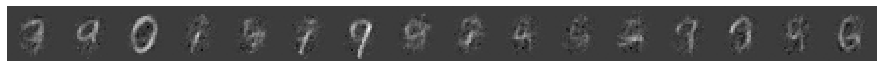

In [ ]:
print('Start Training.')
num_batches_per_epoch = int(N / batch_size)
global_step = tf.Variable(0, trainable=False)

for epoch in range(max_epochs):
  for step, images in enumerate(train_dataset):
    start_time = time.time()
    
    loss, nll, ss, hidden_state = train_step(images)
    global_step.assign_add(1)
    
    if global_step.numpy() % print_steps == 0:
      epochs = epoch + step / float(num_batches_per_epoch)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration)
      display.clear_output(wait=True)
      print("Epochs: {:.2f} global_step: {} loss: {:.3f}  negative log likelihood: {:.3f}  ss: {:.3f}  max_ss: {:.3g}  min_ss: {:.3g}  max_h: {:.3g}  min_h: {:.3g}  ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                epochs, global_step.numpy(), loss, nll, ss,
                nice.log_scaling[tf.argmax(nice.log_scaling)],
                nice.log_scaling[tf.argmin(nice.log_scaling)],
                hidden_state[0][tf.argmax(hidden_state[0])],
                hidden_state[1][tf.argmin(hidden_state[1])],
                examples_per_sec, duration))
      sample_images = nice.generate_sample(random_vector_for_generation)
      print_or_save_sample_images(sample_images.numpy(), num_examples_to_generate)

  if (epoch + 1) % save_images_epochs == 0:
    display.clear_output(wait=True)
    print("This images are saved at {} epoch".format(epoch+1))
    sample_images = nice.generate_sample(random_vector_for_generation)
    print_or_save_sample_images(sample_images.numpy(), num_examples_to_generate,
                                is_square=True, is_save=True, epoch=epoch+1,
                                checkpoint_dir=checkpoint_dir)

  # saving (checkpoint) the model every save_epochs
  if (epoch + 1) % save_model_epochs == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

In [ ]:
# generating after the final epoch
display.clear_output(wait=True)
sample_images = nice.generate_sample(random_vector_for_generation)
print_or_save_sample_images(sample_images.numpy(), num_examples_to_generate,
                            is_square=True, is_save=True, epoch=epoch+1,
                            checkpoint_dir=checkpoint_dir)

## Restore the latest checkpoint

In [20]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Display an image using the epoch number

In [21]:
display_image(max_epochs, checkpoint_dir=checkpoint_dir)

FileNotFoundError: [Errno 2] No such file or directory: 'train/nice/exp1/image_at_epoch_1500.png'

## Generate a GIF of all the saved images.

In [23]:
filename = model_name + '_' + dataset_name + '.gif'
generate_gif(filename, checkpoint_dir)

NameError: name 'dataset_name' is not defined

In [24]:
display.Image(filename=filename + '.png')

NameError: name 'filename' is not defined